# Knowledge graph experiment data generation

In [1]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import trange

In [2]:
n_nodes = 50
n_relations = 5

node_vocab = [f'N{i}' for i in range(n_nodes)]
relation_vocab = [f'R{i}' for i in range(n_relations)]
special_tokens = ['<CTX>', '</CTX>', '<SEP>', '<QUERY>', '</QUERY>', '<EOS>', '<PAD>', '<UNK>']
vocab = node_vocab + relation_vocab + special_tokens
vocab_to_idx = {word: idx for idx, word in enumerate(vocab)}

In [3]:
# randomly generate a graph

# graph parameters
radiuses = [0.2]* n_relations
dims = [2] * n_relations # 2 for now to make it easy to visualize

# generate graph for each relation
# i'm using random geometric graph for now
# roughly, my thinking is that this may correspond to some more "interesting" type of relation which encodes a transitivity property
# we can think about generating this in different ways later
graphs = [nx.random_geometric_graph(n=node_vocab, radius=radiuses[i], dim=dims[i], p=2) for i in range(n_relations)]

# we transform to a DAG

def to_directed(graph):
    graph = graph.to_directed()

    def violate_direction(edge):
        a = int(edge[0][1:])
        b = int(edge[1][1:])
        return a >= b
    edges_to_remove = [edge for edge in graph.edges if violate_direction(edge)]

    graph.remove_edges_from(edges_to_remove )

    return graph

graphs = [to_directed(graph) for graph in graphs]


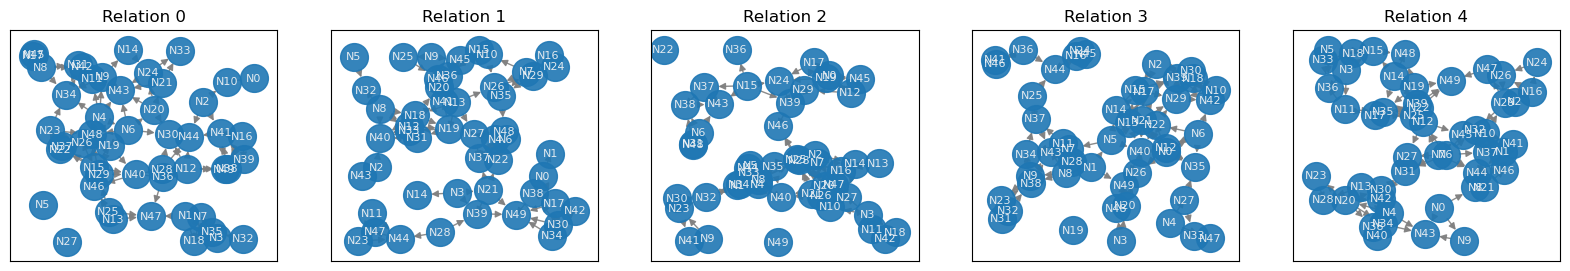

In [4]:
rel = 0

# visualize graphs
fig, axs = plt.subplots(ncols=n_relations, figsize=(4*n_relations,3))
options = {"edge_color": "tab:gray", "node_size": 400, "alpha": 0.9, "node_color": "tab:blue", "font_color": "whitesmoke", "font_size": 8}
for rel in range(n_relations):
    pos = nx.get_node_attributes(graphs[rel], 'pos')
    nx.draw_networkx(graphs[rel], pos=pos, **options, ax=axs[rel])
    axs[rel].set_title(f"Relation {rel}");

In [5]:
facts = {rel: list(graphs[rel].edges) for rel in range(n_relations)}

In [6]:
def sample_fact(return_idx=False):
    # sample relation
    rel = np.random.randint(n_relations)
    # sample fact
    fact_idx = np.random.choice(len(facts[rel]))
    fact = facts[rel][fact_idx]
    n1, n2 = fact
    if return_idx:
        return [vocab_to_idx[n1], vocab_to_idx[f'R{rel}'], vocab_to_idx[n2]]

    return [n1, f'R{rel}', n2]

def sample_falsehood(return_idx=False):
    # sample relation
    rel = np.random.randint(n_relations)

    while True:
        # sample falsehood
        n1, n2 = np.random.choice(node_vocab, size=2)
        if (n1, n2) not in facts[rel]:
            break

    if return_idx:
        return [vocab_to_idx[n1], vocab_to_idx[f'R{rel}'], vocab_to_idx[n2]]

    return [n1, f'R{rel}', n2]


In [7]:
# generate context of true but irrelevant facts
def generate_robustness_example(context_length, return_idx=False):
    # first sample fact for query
    ctx_start = '<CTX>' if not return_idx else vocab_to_idx['<CTX>']
    ctx_end = '</CTX>' if not return_idx else vocab_to_idx['</CTX>']
    sep = '<SEP>' if not return_idx else vocab_to_idx['<SEP>']
    query_start = '<QUERY>' if not return_idx else vocab_to_idx['<QUERY>']
    query_end = '</QUERY>' if not return_idx else vocab_to_idx['</QUERY>']
    eos = '<EOS>' if not return_idx else vocab_to_idx['<EOS>']

    sequence = [ctx_start]

    query_fact = sample_fact(return_idx=return_idx)

    for i in range(context_length):
        # NOTE: for now, not checking if irrelevant; sampling randomly so most likely irrelevant
        ctx_fact = sample_fact(return_idx=return_idx)
        sequence += ctx_fact
        sequence += [sep]

    sequence += [ctx_end, query_start]

    sequence += query_fact
    sequence += [query_end, eos]

    if not return_idx:
        return ' '.join(sequence)

    return sequence


In [8]:
# print some examples of robustness examples
for _ in range(5):
    print(generate_robustness_example(3, return_idx=False))

<CTX> N28 R2 N46 <SEP> N11 R4 N17 <SEP> N36 R0 N40 <SEP> </CTX> <QUERY> N9 R1 N46 </QUERY> <EOS>
<CTX> N23 R2 N41 <SEP> N7 R4 N31 <SEP> N38 R3 N43 <SEP> </CTX> <QUERY> N19 R2 N29 </QUERY> <EOS>
<CTX> N12 R1 N40 <SEP> N28 R3 N43 <SEP> N17 R4 N25 <SEP> </CTX> <QUERY> N22 R0 N37 </QUERY> <EOS>
<CTX> N37 R1 N48 <SEP> N23 R1 N47 <SEP> N15 R2 N39 <SEP> </CTX> <QUERY> N19 R2 N29 </QUERY> <EOS>
<CTX> N10 R1 N15 <SEP> N16 R0 N38 <SEP> N30 R4 N38 <SEP> </CTX> <QUERY> N13 R1 N26 </QUERY> <EOS>


In [9]:
# query is inconsistent with world knowledge
def generate_controllability_example(context_length, insert_pos=None, return_idx=False):
    # first sample fact for query
    ctx_start = '<CTX>' if not return_idx else vocab_to_idx['<CTX>']
    ctx_end = '</CTX>' if not return_idx else vocab_to_idx['</CTX>']
    sep = '<SEP>' if not return_idx else vocab_to_idx['<SEP>']
    query_start = '<QUERY>' if not return_idx else vocab_to_idx['<QUERY>']
    query_end = '</QUERY>' if not return_idx else vocab_to_idx['</QUERY>']
    eos = '<EOS>' if not return_idx else vocab_to_idx['<EOS>']

    sequence = [ctx_start]

    query_fact = sample_falsehood(return_idx=return_idx)

    contexts = []
    for i in range(context_length-1):
        ctx_fact = sample_fact(return_idx=return_idx)
        contexts.append(ctx_fact)

    # insert query fact at random position of context to test controllability
    if insert_pos is None:
        insert_pos = np.random.randint(context_length)
    contexts.insert(insert_pos, query_fact)

    for ctx_fact in contexts:
        sequence += ctx_fact
        sequence += [sep]

    sequence += [ctx_end, query_start]

    sequence += query_fact
    sequence += [query_end, eos]

    if not return_idx:
        return ' '.join(sequence)

    return sequence


In [10]:
# print some examples of robustness examples
for _ in range(5):
    print(generate_controllability_example(3, return_idx=False))

<CTX> N10 R3 N29 <SEP> N16 R2 N27 <SEP> N47 R0 N7 <SEP> </CTX> <QUERY> N47 R0 N7 </QUERY> <EOS>
<CTX> N39 R0 N23 <SEP> N12 R4 N22 <SEP> N5 R2 N35 <SEP> </CTX> <QUERY> N39 R0 N23 </QUERY> <EOS>
<CTX> N37 R0 N28 <SEP> N19 R2 N45 <SEP> N0 R3 N12 <SEP> </CTX> <QUERY> N37 R0 N28 </QUERY> <EOS>
<CTX> N2 R3 N30 <SEP> N41 R3 N46 <SEP> N25 R0 N16 <SEP> </CTX> <QUERY> N25 R0 N16 </QUERY> <EOS>
<CTX> N39 R1 N33 <SEP> N21 R1 N39 <SEP> N34 R2 N44 <SEP> </CTX> <QUERY> N39 R1 N33 </QUERY> <EOS>


In [11]:
# print some examples of robustness examples (print token idx)
for _ in range(5):
    print(generate_controllability_example(3, return_idx=True))

[55, 4, 54, 42, 57, 41, 51, 46, 57, 14, 53, 11, 57, 56, 58, 14, 53, 11, 59, 60]
[55, 27, 53, 35, 57, 2, 51, 4, 57, 0, 54, 8, 57, 56, 58, 2, 51, 4, 59, 60]
[55, 9, 53, 23, 57, 39, 54, 19, 57, 17, 53, 22, 57, 56, 58, 39, 54, 19, 59, 60]
[55, 5, 52, 44, 57, 5, 52, 11, 57, 7, 51, 35, 57, 56, 58, 5, 52, 11, 59, 60]
[55, 8, 54, 46, 57, 18, 53, 29, 57, 40, 54, 17, 57, 56, 58, 40, 54, 17, 59, 60]


In [12]:
# pre-training: "robustness" context_length=0

# training
# w.p. 1/3
# just facts: "robustness" with context_length=0
# w.p. 1/3
# robustness: uniformly context_length=1,2,3
# w.p. 1/3
# controllability: uniformly context_length=1,2,3

# validation
# same but separate context_lengths to different datasets to compute separate metrics

In [13]:
def pad_truncate(sequence, max_length):
    if len(sequence) > max_length:
        sequence = sequence[:max_length]
    elif len(sequence) < max_length:
        sequence += [vocab_to_idx['<PAD>']] * (max_length - len(sequence))

    return sequence

## Create training dataset

In [14]:
# create train_ds
n_examples = 10_000 # total number of examples

p_facts = 1/3 # proportion of facts
p_robustness = 1/3 # proportion of robustness
p_controllability = 1/3 # proportion of controllability
assert (p_facts + p_robustness + p_controllability) == 1 # make sure this makes sense

max_context_statements = 3 # maximum number of context facts; sample uniformly from 1,2,3
max_block_length = len(generate_robustness_example(3, return_idx=True)) # get the block length of the longest example

n_facts = int(n_examples * p_facts)
n_robustness = int(n_examples * p_robustness)
n_controllability = int(n_examples * p_controllability)

In [15]:
train_data = []

for _ in trange(n_facts):
    example = generate_robustness_example(0, return_idx=True)
    example = pad_truncate(example, max_block_length)
    train_data.append(example)

for _ in trange(n_robustness):
    n_context_statements = np.random.randint(1, max_context_statements+1)
    example = generate_robustness_example(n_context_statements, return_idx=True)
    example = pad_truncate(example, max_block_length)
    train_data.append(example)

for _ in trange(n_controllability):
    n_context_statements = np.random.randint(1, max_context_statements+1)
    insert_pos = np.random.randint(n_context_statements)
    example = generate_controllability_example(n_context_statements, insert_pos=insert_pos, return_idx=True)
    example = pad_truncate(example, max_block_length)
    train_data.append(example)


100%|██████████| 3333/3333 [00:00<00:00, 14995.93it/s]


In [16]:
# create and save
train_ds_tensor = torch.tensor(train_data, dtype=torch.int64)
# np.random.shuffle(train_ds)
torch.save(train_ds_tensor, '../data/knowledge_graph_train_ds.pt')

In [17]:
train_ds_tensor = torch.load('../data/knowledge_graph_train_ds.pt')

In [18]:
def generate_val_data(type, n_context_statements, n_examples, max_block_length=max_block_length):
    example_generator = generate_robustness_example if type == 'robustness' else generate_controllability_example
    val_data = []
    for _ in trange(n_examples):
        example = example_generator(n_context_statements, return_idx=True)
        example = pad_truncate(example, max_block_length)
        val_data.append(example)

    return torch.tensor(val_data)


In [19]:
for type in ['robustness', 'controllability']:
    for n_context_statements in range(1, max_context_statements+1):
        n_examples = 1_000
        val_data = generate_val_data(type, n_context_statements, n_examples)
        torch.save(val_data, f'../data/knowledge_graph_val_ds_{type}_{n_context_statements}.pt')

100%|██████████| 1000/1000 [00:00<00:00, 6389.50it/s]


### Demo on how to load data

In [20]:
# how to load data and createe data loader
import sys; sys.path.append('../')
from data_utils import LanguageModelTensorDataset
train_ds = LanguageModelTensorDataset(train_ds_tensor)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=1, shuffle=True)

In [21]:
# some examples from train__ds_tensor
for x in train_ds_tensor[:5]:
    print(x.tolist())
    print(' '.join([vocab[idx] for idx in x]))
    print()

[55, 56, 58, 2, 52, 20, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
<CTX> </CTX> <QUERY> N2 R2 N20 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

[55, 56, 58, 15, 50, 37, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
<CTX> </CTX> <QUERY> N15 R0 N37 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

[55, 56, 58, 17, 54, 35, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
<CTX> </CTX> <QUERY> N17 R4 N35 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

[55, 56, 58, 19, 54, 49, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
<CTX> </CTX> <QUERY> N19 R4 N49 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

[55, 56, 58, 9, 50, 11, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
<CTX> </CTX> <QUERY> N9 R0 N11 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [22]:
# some examples from train_dl
train_iter = iter(train_dl)
for _ in range(5):
    # get next from train_dl
    x, y = next(train_iter)
    x, y = x.squeeze(), y.squeeze()
    print('INPUT')
    print(x.tolist())
    print(' '.join([vocab[idx] for idx in x]))
    print('TARGET')
    print(y.tolist())
    print(' '.join([vocab[idx] for idx in y]))
    print('-'*100)
    print()

INPUT
[55, 27, 50, 30, 57, 56, 58, 27, 50, 30, 59, 60, 61, 61, 61, 61, 61, 61, 61]
<CTX> N27 R0 N30 <SEP> </CTX> <QUERY> N27 R0 N30 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
TARGET
[27, 50, 30, 57, 56, 58, 27, 50, 30, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61]
N27 R0 N30 <SEP> </CTX> <QUERY> N27 R0 N30 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
----------------------------------------------------------------------------------------------------

INPUT
[55, 4, 51, 22, 57, 4, 53, 27, 57, 56, 58, 7, 54, 44, 59, 60, 61, 61, 61]
<CTX> N4 R1 N22 <SEP> N4 R3 N27 <SEP> </CTX> <QUERY> N7 R4 N44 </QUERY> <EOS> <PAD> <PAD> <PAD>
TARGET
[4, 51, 22, 57, 4, 53, 27, 57, 56, 58, 7, 54, 44, 59, 60, 61, 61, 61, 61]
N4 R1 N22 <SEP> N4 R3 N27 <SEP> </CTX> <QUERY> N7 R4 N44 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>
----------------------------------------------------------------------------------------------------

INPUT
[55, 27, 53, 35, 57, 34, 53, 38, 57, 9, 54, 43, 57, 56, 58